In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(f'Data/Playlist Data Train.csv')

# Multicollinearity and Correlation

>> Correlation

Text(0.5, 1.0, 'Correlation Heatmap')

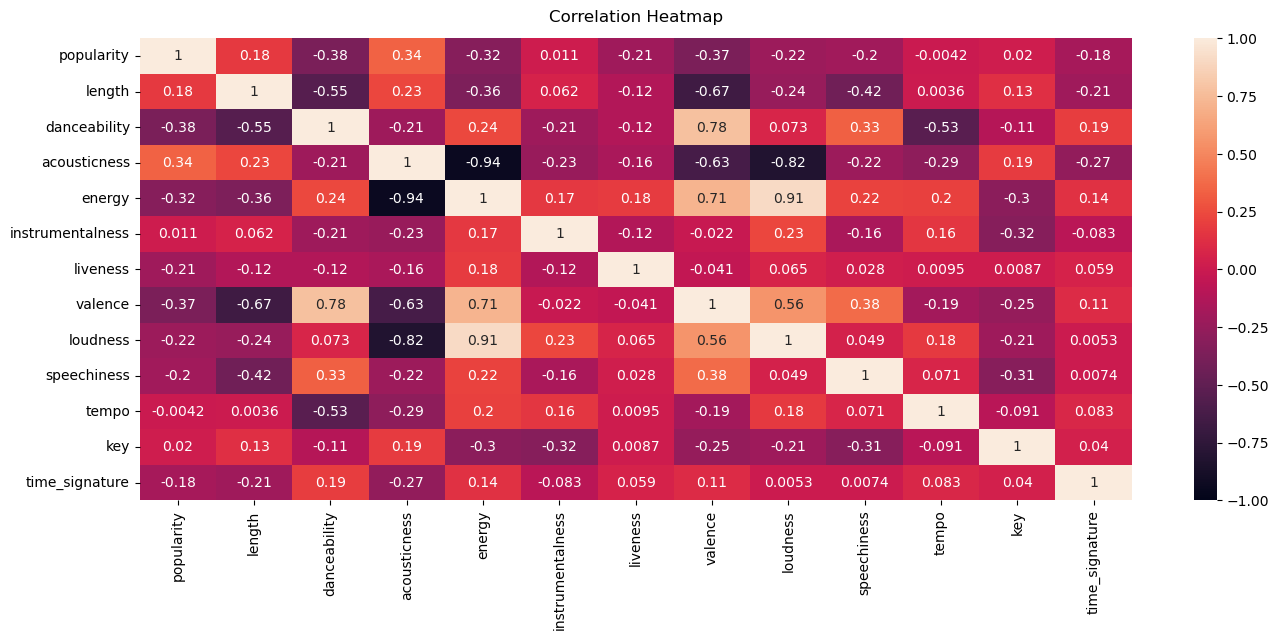

In [9]:
plt.figure(figsize=(16,6))
heat = sns.heatmap(df.drop(columns=['name', 'album', 'artist', 'id', 'release_date']).corr().corr(), annot = True, vmin=-1, vmax=1)
heat.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

>> Multicollinearity

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X, threshold=5):
    """
    Iteratively removes features with high VIF.

    Parameters:
        X (pd.DataFrame): Feature matrix.
        threshold (float): VIF threshold for removal.

    Returns:
        pd.DataFrame: Dataframe with remaining features and their VIFs.
    """
    X = X.copy()
    dropped = True

    while dropped:
        vif_data = pd.DataFrame()
        vif_data["feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

        max_vif = vif_data["VIF"].max()

        if max_vif > threshold:
            feature_to_drop = vif_data.sort_values("VIF", ascending=False)["feature"].iloc[0]
            X.drop(columns=[feature_to_drop], inplace=True)
            print(f"Dropping {feature_to_drop} with VIF: {max_vif}")
        else:
            dropped = False

    return vif_data.sort_values("VIF", ascending=True)

In [41]:
X = df[['popularity', 'length','danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo', 'key','time_signature']]

final_vif = calculate_vif(X, threshold=5)

print(final_vif)

Dropping time_signature with VIF: 225.20013845558927
Dropping danceability with VIF: 42.95010466759368
Dropping energy with VIF: 39.42503687631219
Dropping length with VIF: 28.97526978628214
Dropping popularity with VIF: 16.50929791979962
Dropping tempo with VIF: 12.322645241742027
Dropping loudness with VIF: 8.34223110301488
            feature       VIF
1  instrumentalness  1.039092
0      acousticness  1.910053
4       speechiness  2.519714
5               key  2.742292
2          liveness  3.020146
3           valence  4.712148


In [33]:
datatest = df[[ 'acousticness',  'instrumentalness','liveness', 'valence', 'speechiness', 'key']]

# Preprocessing

In [42]:
from sklearn.preprocessing import StandardScaler
x = df[['acousticness',  'instrumentalness',
       'liveness', 'valence', 'speechiness', 'key'
       ]]
x = StandardScaler().fit_transform(x)

In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

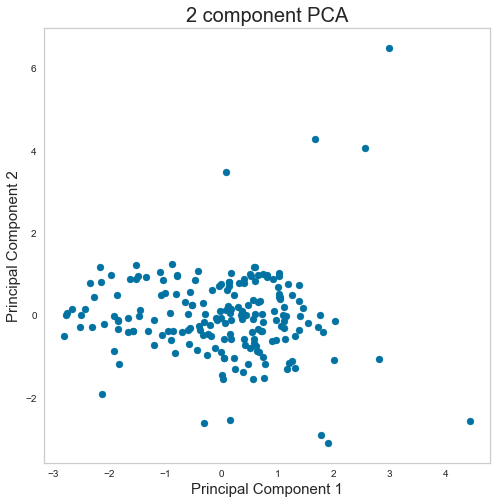

In [41]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
colors = ['r', 'g', 'b']
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
ax.grid()

# **Modelling**

In [23]:
from sklearn.mixture import GaussianMixture 
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.metrics import silhouette_score

In [43]:
X = x.copy()

## Determine N Cluster using Elbow and Silhouette Score

/tmp/ipykernel_776/1313050382.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(K, wcss, 'bx-', label='WCSS (Elbow)', color='blue')
/tmp/ipykernel_776/1313050382.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(K, silhouette_scores, 'ro-', label='Silhouette Score', color='red')


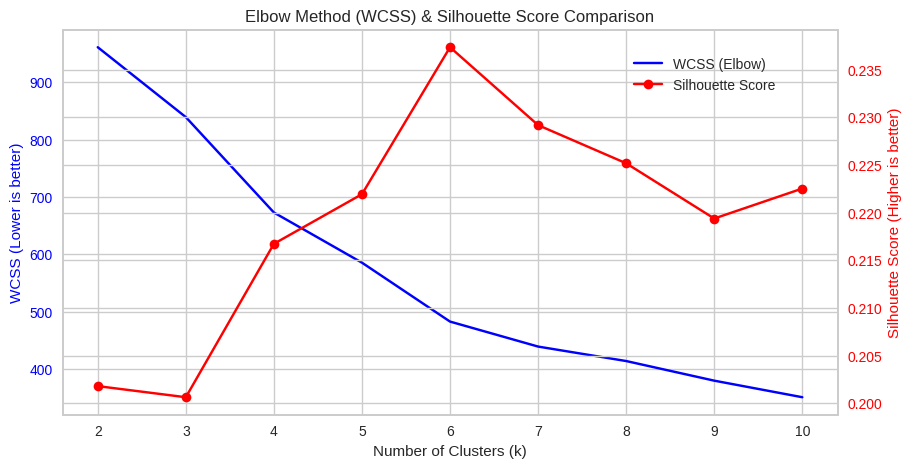

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define range of clusters to test
K = list(range(2, 11))  # Start from 2 because silhouette score is undefined for k=1

# Lists to store results
wcss = []  # Within-Cluster Sum of Squares (Elbow)
silhouette_scores = []  # Silhouette Score

# Compute scores for each k
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    wcss.append(kmeans.inertia_)  # WCSS (Elbow Score)
    silhouette_scores.append(silhouette_score(X, cluster_labels))  # Silhouette Score

# Plot Elbow and Silhouette Score together
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot WCSS (Elbow Method)
ax1.plot(K, wcss, 'bx-', label='WCSS (Elbow)', color='blue')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('WCSS (Lower is better)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for Silhouette Score
ax2 = ax1.twinx()
ax2.plot(K, silhouette_scores, 'ro-', label='Silhouette Score', color='red')
ax2.set_ylabel('Silhouette Score (Higher is better)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and legends
plt.title('Elbow Method (WCSS) & Silhouette Score Comparison')
fig.legend(loc="upper right", bbox_to_anchor=(0.85,0.85))
plt.show()


## Model

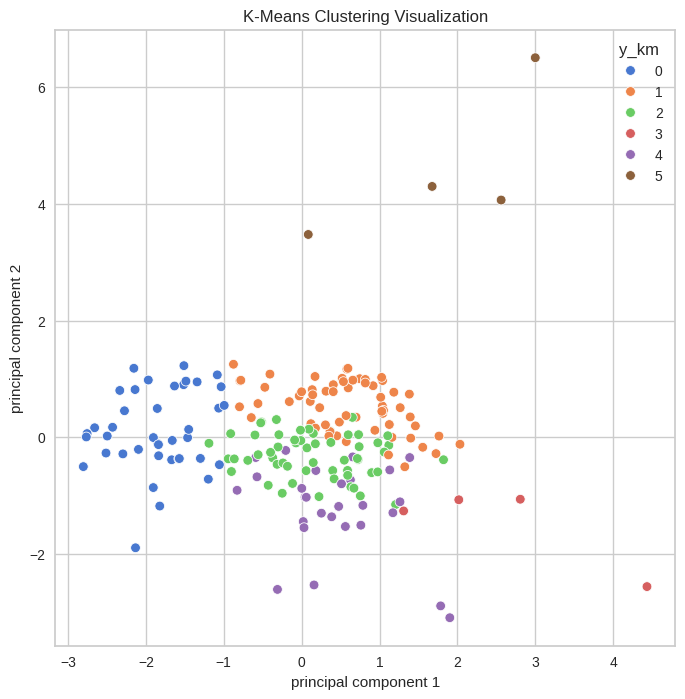

In [61]:
X = x.copy()

km = KMeans(
    n_clusters=6, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

X = principalDf.copy()
X['y_km'] = y_km

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1) 

sns.scatterplot(x='principal component 1', y='principal component 2', hue='y_km', data=X, palette='muted')

plt.title("K-Means Clustering Visualization")
plt.show()

In [64]:
datatest['Cluster'] = y_km
df['Cluster'] = y_km

dataend = df.copy()
dataend = dataend.sort_values(['Cluster'])
dataend = dataend.reset_index(drop=True)

datavis = dataend[['popularity', 'length',
       'danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo', 'key',
       'time_signature', 'Cluster']]

/tmp/ipykernel_776/1750882951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datatest['Cluster'] = y_km


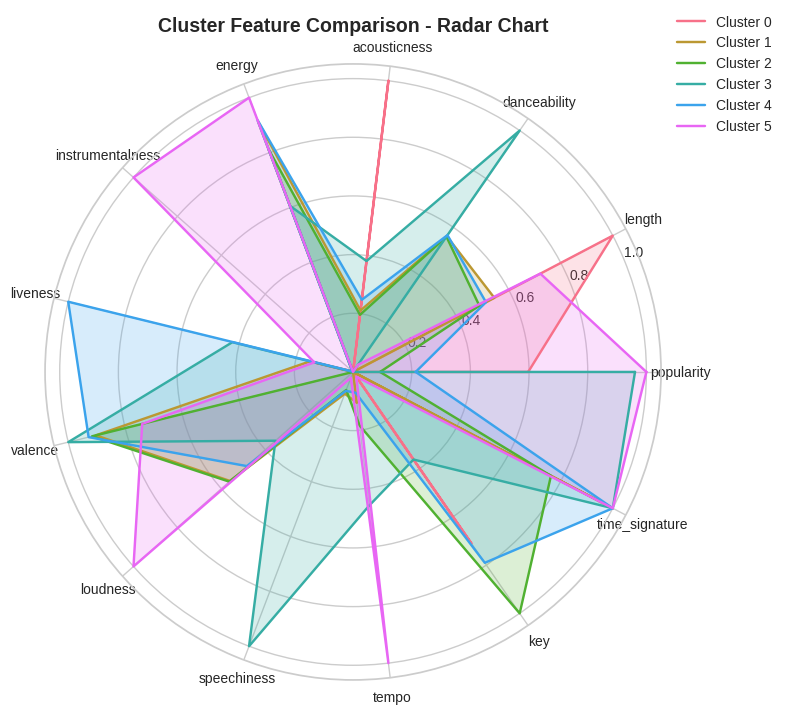

In [71]:

features = ['popularity', 'length', 'danceability', 'acousticness', 'energy',
            'instrumentalness', 'liveness', 'valence', 'loudness', 'speechiness',
            'tempo', 'key', 'time_signature']

cluster_means = datavis.groupby('Cluster')[features].mean()

normalized_means = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

clusters = cluster_means.index.tolist()

num_vars = len(features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

palette = sns.color_palette("husl", len(clusters))

for i, cluster in enumerate(clusters):
    values = normalized_means.loc[cluster].tolist()
    values += values[:1]  # Close the radar chart
    ax.plot(angles, values, label=f'Cluster {cluster}', color=palette[i])
    ax.fill(angles, values, alpha=0.2, color=palette[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=10)

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.title("Cluster Feature Comparison - Radar Chart", fontsize=14, fontweight='bold')

plt.show()


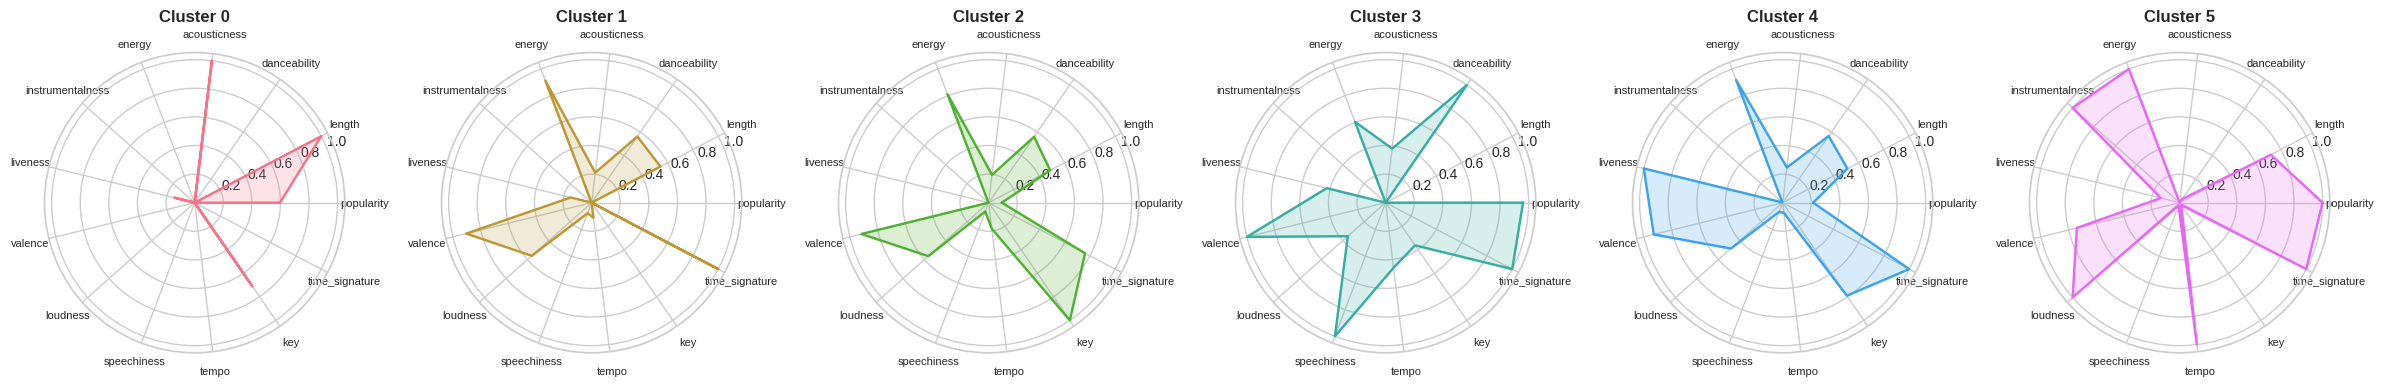

In [72]:
features = ['popularity', 'length', 'danceability', 'acousticness', 'energy',
            'instrumentalness', 'liveness', 'valence', 'loudness', 'speechiness',
            'tempo', 'key', 'time_signature']

cluster_means = datavis.groupby('Cluster')[features].mean()

normalized_means = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

clusters = cluster_means.index.tolist()

num_vars = len(features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 

fig, axes = plt.subplots(nrows=1, ncols=len(clusters), figsize=(len(clusters) * 4, 6), subplot_kw=dict(polar=True))
palette = sns.color_palette("husl", len(clusters))

if len(clusters) == 1:
    axes = [axes]

for i, cluster in enumerate(clusters):
    values = normalized_means.loc[cluster].tolist()
    values += values[:1]  

    ax = axes[i]
    ax.plot(angles, values, label=f'Cluster {cluster}', color=palette[i])
    ax.fill(angles, values, alpha=0.2, color=palette[i])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=8)

    ax.set_title(f'Cluster {cluster}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
dataend.to_csv(f"Data/Data Upload.csv", encoding='utf-8')